In [74]:
import os
from zipfile import ZipFile
from pathlib import Path
import requests

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.family"] = "DejaVu Sans"

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [75]:
def load_har_dataset(url, extract_path: Path, filename: str, overwrite=False):
    # check if existed already
    filepath = extract_path / filename
    if filepath.exists() and not overwrite:
        print("The dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    with open(filepath, 'wb') as f:
        f.write(response.content)

    with ZipFile(filepath, 'r') as zipObj:
        # Extract all the contents of zip file in current directory
        zipObj.extractall(extract_path)

In [76]:
data_path = '../mlcourse.ai_Dataset/'

In [77]:
X_train = np.loadtxt(data_path + 'samsung_train.txt')
y_train = np.loadtxt(data_path + 'samsung_train_labels.txt').astype(int)

X_test = np.loadtxt(data_path + 'samsung_test.txt')
y_test = np.loadtxt(data_path + 'samsung_test_labels.txt').astype(int)

In [78]:
# Checking dimensions
assert X_train.shape == (7352, 561) and y_train.shape == (7352,)
assert X_test.shape == (2947, 561) and y_test.shape == (2947,)

In [79]:
X_train.shape

(7352, 561)

In [80]:
X_test.shape

(2947, 561)

In [81]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

In [82]:
X.shape

(10299, 561)

In [83]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [84]:
n_classes = np.unique(y).size

In [85]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [86]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

In [87]:
X_pca.shape

(10299, 65)

In [88]:
print(f'The amount of variance covered by first PC: {pca.explained_variance_ratio_[0]*100}%')

The amount of variance covered by first PC: 50.73822103501329%


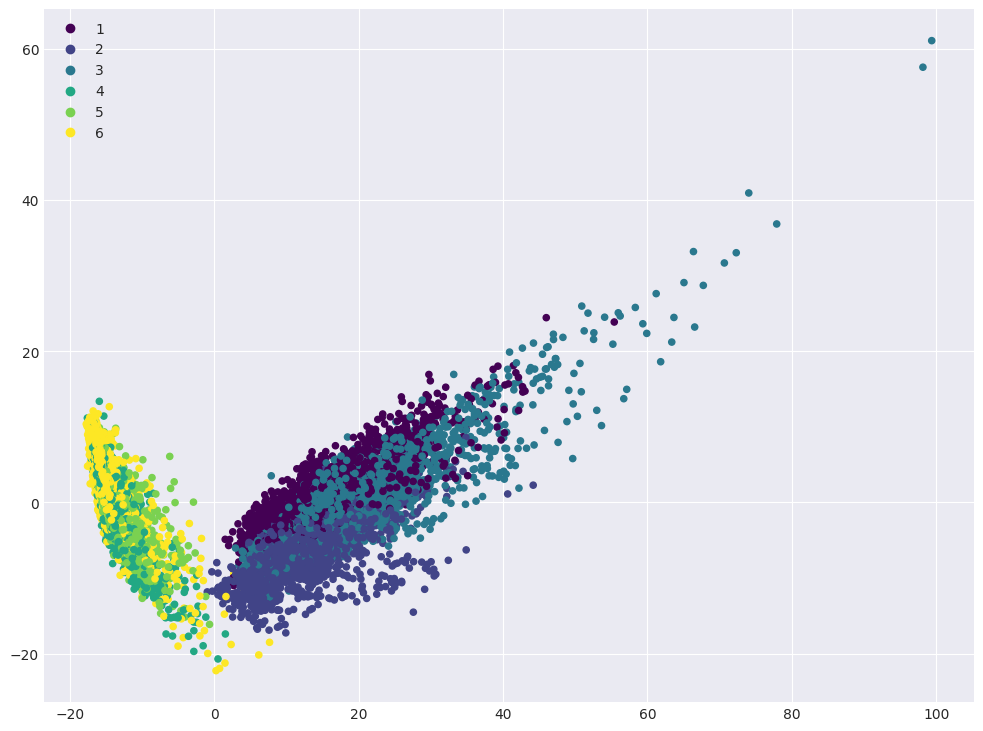

In [109]:
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=20, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=np.char.mod('%s', np.unique(y)).tolist())

In [112]:
k_means = KMeans(n_clusters=np.unique(y).size, n_init=100, random_state=RANDOM_STATE)

y_pred = k_means.fit(X_pca).labels_

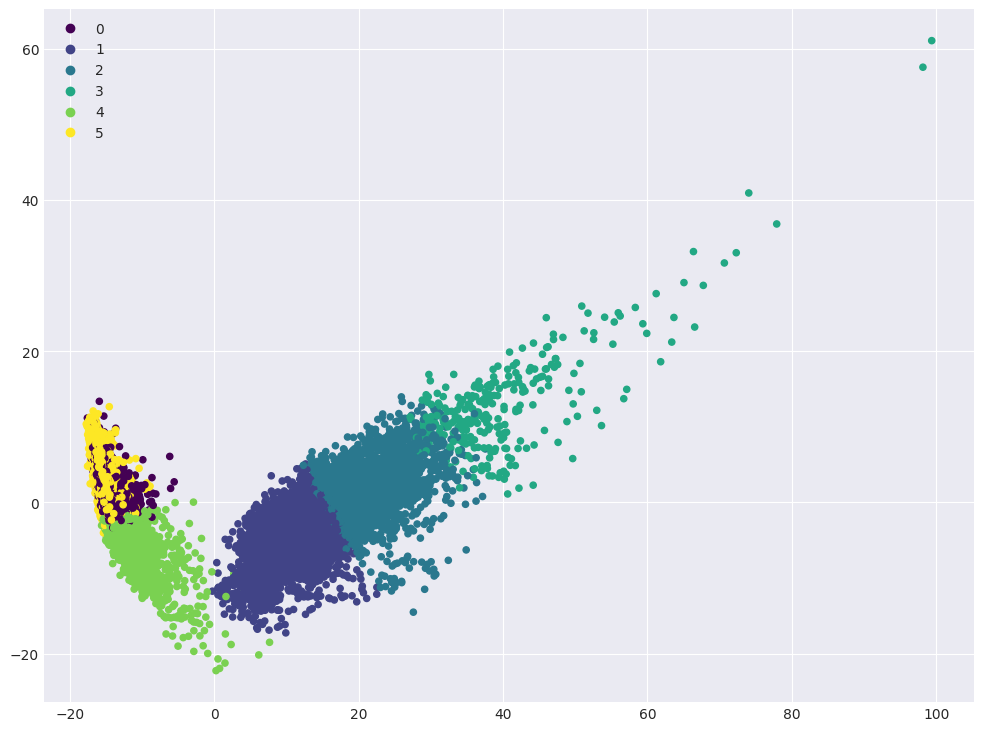

In [113]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred, s=20, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=np.char.mod('%s', np.unique(y_pred)).tolist())

In [115]:
tab = pd.crosstab(y, y_pred, margins=True)
tab.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,0,903,741,78,0,0,1722
going up the stairs,0,1241,296,5,2,0,1544
going down the stairs,0,320,890,196,0,0,1406
sitting,1235,1,0,0,450,91,1777
standing,1344,0,0,0,562,0,1906
laying,52,5,0,0,329,1558,1944
all,2631,2470,1927,279,1343,1649,10299


In [133]:
for index, data in tab.iterrows():
    print(f'{index}\t\t\t -> {np.max(data[:-1])/data[-1]}')

walking			 -> 0.524390243902439
going up the stairs			 -> 0.8037564766839378
going down the stairs			 -> 0.6330014224751067
sitting			 -> 0.694991558806978
standing			 -> 0.7051416579223505
laying			 -> 0.801440329218107
all			 -> 0.2554616953102243


C:\Users\vitalijs.tickovs\AppData\Local\Temp\ipykernel_30840\2132634.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'{index}\t\t\t -> {np.max(data[:-1])/data[-1]}')


In [134]:
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    k_means = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(k_means.inertia_)

C:\Users\vitalijs.tickovs\AppData\Local\Temp\ipykernel_30840\3575008283.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

Text(0, 0.5, '$J(C_k)$')

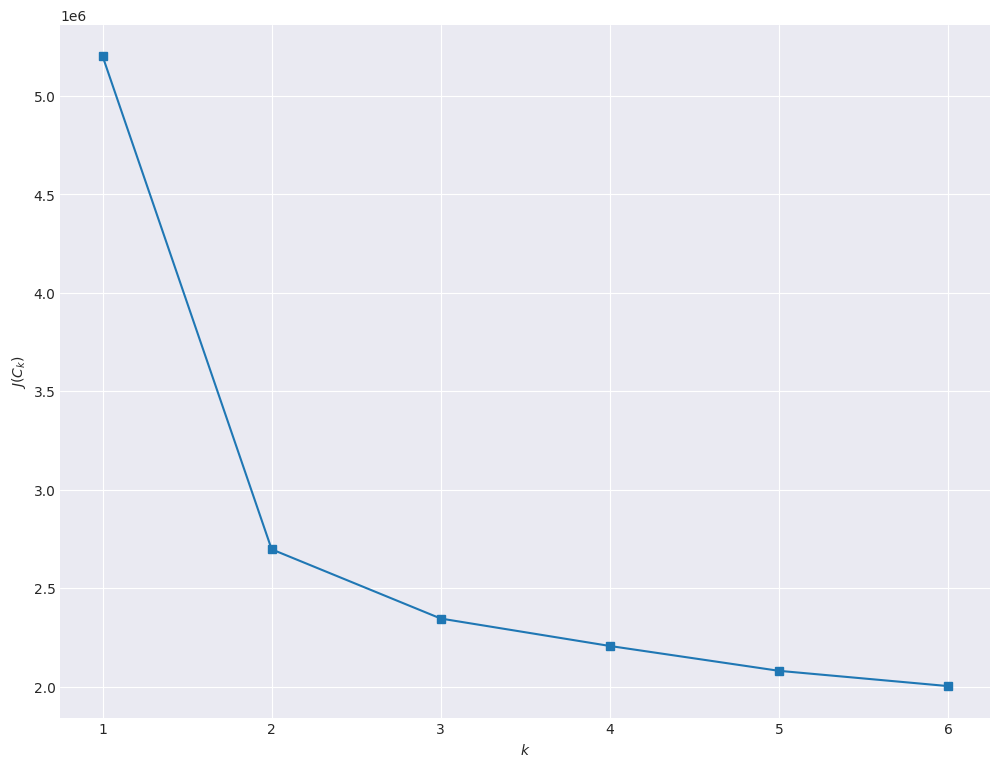

In [137]:
plt.plot(range(1, n_classes + 1), inertia, marker="s")
plt.xlabel("$k$")
plt.ylabel("$J(C_k)$")

In [139]:
ag_pred = AgglomerativeClustering(n_clusters=n_classes,
                             linkage='ward').fit_predict(X_pca)
metrics.adjusted_rand_score(y, ag_pred)

0.49362763373004886

In [141]:
k_means_pred = KMeans(n_clusters=6, n_init=100, random_state=RANDOM_STATE).fit_predict(X_pca)

metrics.adjusted_rand_score(y,k_means_pred)

0.4198070012602345

In [144]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {"C": [0.001, 0.01, 0.1, 1, 10]}

In [ ]:
best_svc = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1)
best_svc.fit(X_train_scaled, y_train)

best_svc.best_params_, best_svc.best_score_

In [ ]:
y_predicted = best_svc.predict(X_test_scaled)

tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab.columns = ['walking', 'climbing up the stairs',
             'going down the stairs', 'sitting', 'standing', 'laying', 'all']
tab

In [148]:
X_train_scaled_pca = pca.fit_transform(X_train_scaled)

X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
best_svc_pca = GridSearchCV(svc, svc_params, n_jobs=-1, cv=3)
best_svc_pca.fit(X_train_scaled_pca, y_train)

In [ ]:
best_svc_pca.best_params_, best_svc_pca.best_score_

In [ ]:
round(100 * (best_svc_pca.best_score_ - best_svc.best_score_))